Parte 3
===

In [38]:
import warnings as ws
ws.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## 1. Carga de la base de datos

In [2]:
df = pd.read_csv('data/result.csv', sep=";", encoding='utf-8')

df.shape

(42688, 34)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42688 entries, 0 to 42687
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Creditos                           42688 non-null  int64  
 1   saldo_actual                       42688 non-null  float64
 2   Promedio de limite_credito         42688 non-null  float64
 3   Promedio de credito_maximo         42688 non-null  float64
 4   Promedio de cantidad_cuotas        42688 non-null  float64
 5   Promedio de valor_cuota            42688 non-null  float64
 6   coaching_impacto                   42688 non-null  int64  
 7   Comunicaciones_saldo_actual        42688 non-null  float64
 8   %_comunicaciones                   42688 non-null  float64
 9   Comunicaciones_garantia            42688 non-null  int64  
 10  Consumo_saldo_actual               42688 non-null  float64
 11  %_consumo                          42688 non-null  flo

## 2. Segmentación de usuarios

Para realizar la segmentación de usuarios tenemos diferentes posibilidades de metodologías. Para efecto de este trabajo usaremos únicamente **KMeans** y realizaremos un ajuste basado en el **método del codo** para seleccionar una cantidad de grupos o segmentos apropiados para el problema.

In [44]:
# Eliminamos la variable objetivo ya que no aporta en la segmentación
group_df = df.drop(columns="Y")

# Dejemos escalados los datos para el modelado de Clustering
scaler, columns = MinMaxScaler(), group_df.columns
group_scaled_df = pd.DataFrame(scaler.fit_transform(group_df), columns=columns)

group_scaled_df.shape

(42688, 33)

In [45]:
group_scaled_df.head()

,Creditos,saldo_actual,Promedio de limite_credito,Promedio de credito_maximo,Promedio de cantidad_cuotas,Promedio de valor_cuota,coaching_impacto,Comunicaciones_saldo_actual,%_comunicaciones,Comunicaciones_garantia,...,mop_historico_Mora > 120 días,mop_historico_Sin registro,perfil_usuario_Alto,perfil_usuario_Bajo,perfil_usuario_Joven,perfil_usuario_Medio,perfil_usuario_Sin registro,perfil_usuario_Usuario en quiebra,Garantia_Tipo garantia 1,Garantia_Tipo garantia 2
0,0.00,0.002763,0.000000,0.029817,0.081013,0.001905,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.00,0.000289,0.000000,0.007488,0.001688,0.032604,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.00,0.008450,0.000000,0.067551,0.163713,0.002831,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.04,0.002499,0.078508,0.000000,0.000000,0.000874,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.04,0.004491,0.000000,0.028820,0.081013,0.001750,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


### Selección cantidad de segmentos

Vamos a ejecutar el método KMeans de forma iterativa para diferentes tamaños de cluster, desde 1 hasta 9. Luego, vamos a graficar y validar en que cantidad de cluster se comporta mejor.

In [46]:
distortions = []
range_ = range(1, 10)
for k in range_:
    model = KMeans(n_clusters=k)
    model.fit(group_scaled_df)
    distortions.append(model.inertia_)

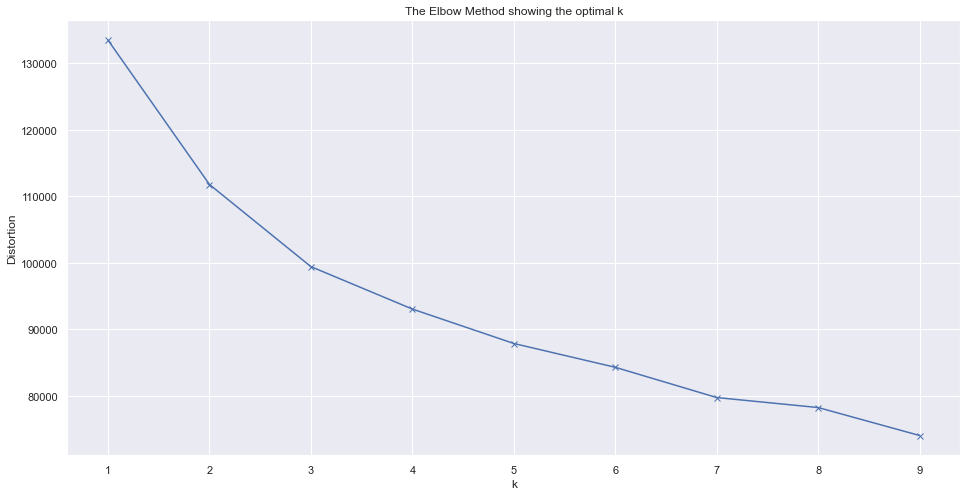

In [47]:
plt.figure(figsize=(16,8))
plt.plot(range_, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [48]:
model_final = KMeans(n_clusters=3)
model_final.fit(group_scaled_df)

pd.Series(model_final.labels_).value_counts()

0    17146
2    13756
1    11786
dtype: int64

In [49]:
grouped_df = group_df.copy()
grouped_df['cluster'] = model_final.labels_

grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42688 entries, 0 to 42687
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Creditos                           42688 non-null  int64  
 1   saldo_actual                       42688 non-null  float64
 2   Promedio de limite_credito         42688 non-null  float64
 3   Promedio de credito_maximo         42688 non-null  float64
 4   Promedio de cantidad_cuotas        42688 non-null  float64
 5   Promedio de valor_cuota            42688 non-null  float64
 6   coaching_impacto                   42688 non-null  int64  
 7   Comunicaciones_saldo_actual        42688 non-null  float64
 8   %_comunicaciones                   42688 non-null  float64
 9   Comunicaciones_garantia            42688 non-null  int64  
 10  Consumo_saldo_actual               42688 non-null  float64
 11  %_consumo                          42688 non-null  flo

### Evaluación del modelo seleccionado

In [52]:
model_reduce_dim = PCA(n_components=2, random_state=1)
# model_reduce_dim = TSNE(n_components=2, random_state=1)

transformed = model_reduce_dim.fit_transform(grouped_df)
transformed.shape

(42688, 2)

<AxesSubplot:title={'center':'Flattened Graph of KMeans(n_clusters=3) model'}>

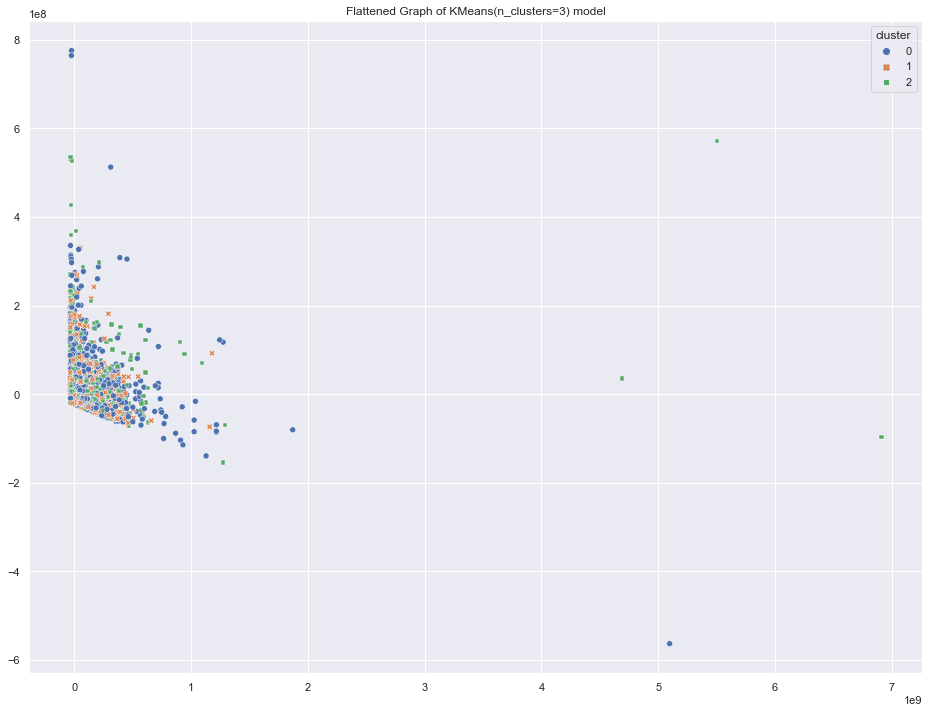

In [53]:
plt.figure(figsize=(16, 12))
plt.title(f'Flattened Graph of {str(model_final)} model')
sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=grouped_df.cluster, 
                style=grouped_df.cluster, palette='deep')

### Evaluación modelo de segmentación seleccionado

In [12]:
def model_plot(df, scaler, model):
    normalized_df = pd.DataFrame(scaler.fit_transform(df))
    normalized_df.columns = df.columns
    
    # Extract cluster labels
    model.fit(normalized_df)
    cluster_labels = model.labels_
        
    # Create a cluster label column in original dataset
    df_new = df.assign(cluster=cluster_labels)
    
    # Initialise TSNE
    model_tsne = TSNE(n_components=3, random_state=1)
    transformed = model_tsne.fit_transform(df_new)
    
    fig = plt.figure()
    fig.set_size_inches(12, 12)
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(xs=transformed[:,0], ys=transformed[:,1], zs=transformed[:,2], 
               c=df_new.cluster, cmap='Set1')
    ax.set_title(f'Flattened Graph of {str(model)} model')
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    
    plt.show()

def model_plot_2d(df, scaler, model):
    normalized_df = pd.DataFrame(scaler.fit_transform(df))
    normalized_df.columns = df.columns
    
    # Extract cluster labels
    cluster_labels = None
    if str(model).split('(')[0] == 'GaussianMixture':
        cluster_labels = model.fit_predict(normalized_df)
    else:
        model.fit(normalized_df)
        cluster_labels = model.labels_
        
    # Create a cluster label column in original dataset
    df_new = df.assign(cluster=cluster_labels)
    
    # Initialise TSNE
    model_tsne = TSNE(random_state=1)
    transformed = model_tsne.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title(f'Flattened Graph of {str(model)} model')
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, 
                    style=cluster_labels, palette='deep')
    
    return normalized_df, df_new

def snake_plot(normalized_df, df_cluster, df_original, columns_vars):

    normalized_df = pd.DataFrame(normalized_df.values, 
                                 index=df_original.index, 
                                 columns=df_original.columns)
    
    normalized_df['cluster'] = df_cluster['cluster']

    # Melt data into long format
    df_melt = pd.melt(normalized_df.reset_index(), 
                      id_vars=['saldo_actual', 'cluster'],
                      value_vars=columns_vars,
                      var_name='metric', 
                      value_name='value')
    plt.xlabel('metric')
    plt.ylabel('value')
    sns.pointplot(data=df_melt, x='metric', y='value', hue='cluster', palette="Set2")
    
    return